<h1 style="font-size:2em">Projet 5 - Segmentez des clients d'un site e-commerce</h1>


# Objectifs

- **Olist:** Entreprise Brésilienne un service qui aide les commerçants/entreprises à vendre leurs produits sur diverses marketplaces en ligne (Amazon, Ebay...)  

**2 Objectifs:** 
- **Segmentation des clients:** Permettera de mieux appréhender les campagnes de communication
- **Proposition de contrat de maintenance:** Sera basée sur une analyse de la stabilité des segments au cours du temps
    - Cela signifie qu'il faut proposer une fréquence à laquelle la segmentation doit être mise à jour pour rester pertinente

**Base de données (Anonymisée):**
- Informations sur l’historique de commandes
- Produits achetés
- Commentaires de satisfaction
- Localisation des clients depuis janvier 2017

**Infos pertinantes à considérer:**
- Seuls 3 % des clients du fichier de données ont réalisé plusieurs commandes
- La segmentation doit pouvoir différencier les bons et moins bons clients en termes de commandes et de satisfaction
- Le code doit respecter **la convention PEP8**

## Convention PEP8 (Python Enhancement Proposal 8)

**Convention de codage pour le langage de programmation Python:**
- **Indentation:** Utiliser 4 espaces par niveau d'indentation. Les tabulations ne sont pas recommandées.
- **Longueur de ligne:** Chaque ligne de code ne doit pas dépasser 79 caractères.
- **Espaces blancs:** Éviter les espaces blancs inutiles à la fin des lignes ou sur les lignes vides.
- **Importations:** Les modules doivent être importés sur des lignes séparées et ils doivent être placés en haut du fichier.
- **Commentaires:** Ils doivent être complets et compréhensibles. Ils doivent être insérés sur une nouvelle ligne si possible.
- **Nommage des variables:** Les noms des variables doivent être descriptifs, en minuscules, avec des mots séparés par des underscores si nécessaire.

In [1]:
# Importations: Les modules doivent être importés sur des lignes séparées 
# et ils doivent être placés en haut du fichier.
import os
import sys

def process_data(data):  
    """
    Commentaires: Ils doivent être complets et compréhensibles. 
    Ils doivent être insérés sur une nouvelle ligne si possible. 
    Cette fonction traite les données passées en argument.
    """
    # Indentation: Utiliser 4 espaces par niveau d'indentation. 
    # Les tabulations ne sont pas recommandées.
    for item in data:  
        # Nommage des variables: Les noms des variables doivent être descriptifs, 
        # en minuscules, avec des mots séparés par des underscores si nécessaire.
        # Longueur de ligne: Chaque ligne de code ne doit pas dépasser 79 caractères.
        processed_item = item * 2  
        print(processed_item)

## Notebooks

- **Notebook1:** Analyse exploratoire
    - Cleaning
    - Feature engineering
    - Exploration
- **Notebook2:** Essais des différentes approches de modélisation (segmentation)
    - Plusieurs modèles de segmentation à considérer
    - Recherche des bons hyperparamètres
- **Notebook3:** Simulations pour déterminer la fréquence nécessaire de mise à jour du modèle de segmentation

# Imports et configs

In [2]:
import pandas as pd 
pd.set_option('display.max_columns', None)

In [3]:
import pandas as pd 
customers = pd.read_csv('olist_customers_dataset.csv', sep = ",")
geolocation = pd.read_csv('olist_geolocation_dataset.csv', sep = ",")
order_items = pd.read_csv('olist_order_items_dataset.csv', sep = ",")
order_payments = pd.read_csv('olist_order_payments_dataset.csv', sep = ",")
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv', sep = ",")
orders = pd.read_csv('olist_orders_dataset.csv', sep = ",")
products = pd.read_csv('olist_products_dataset.csv', sep = ",")
sellers = pd.read_csv('olist_sellers_dataset.csv', sep = ",")
translation = pd.read_csv('product_category_name_translation.csv', sep = ",")

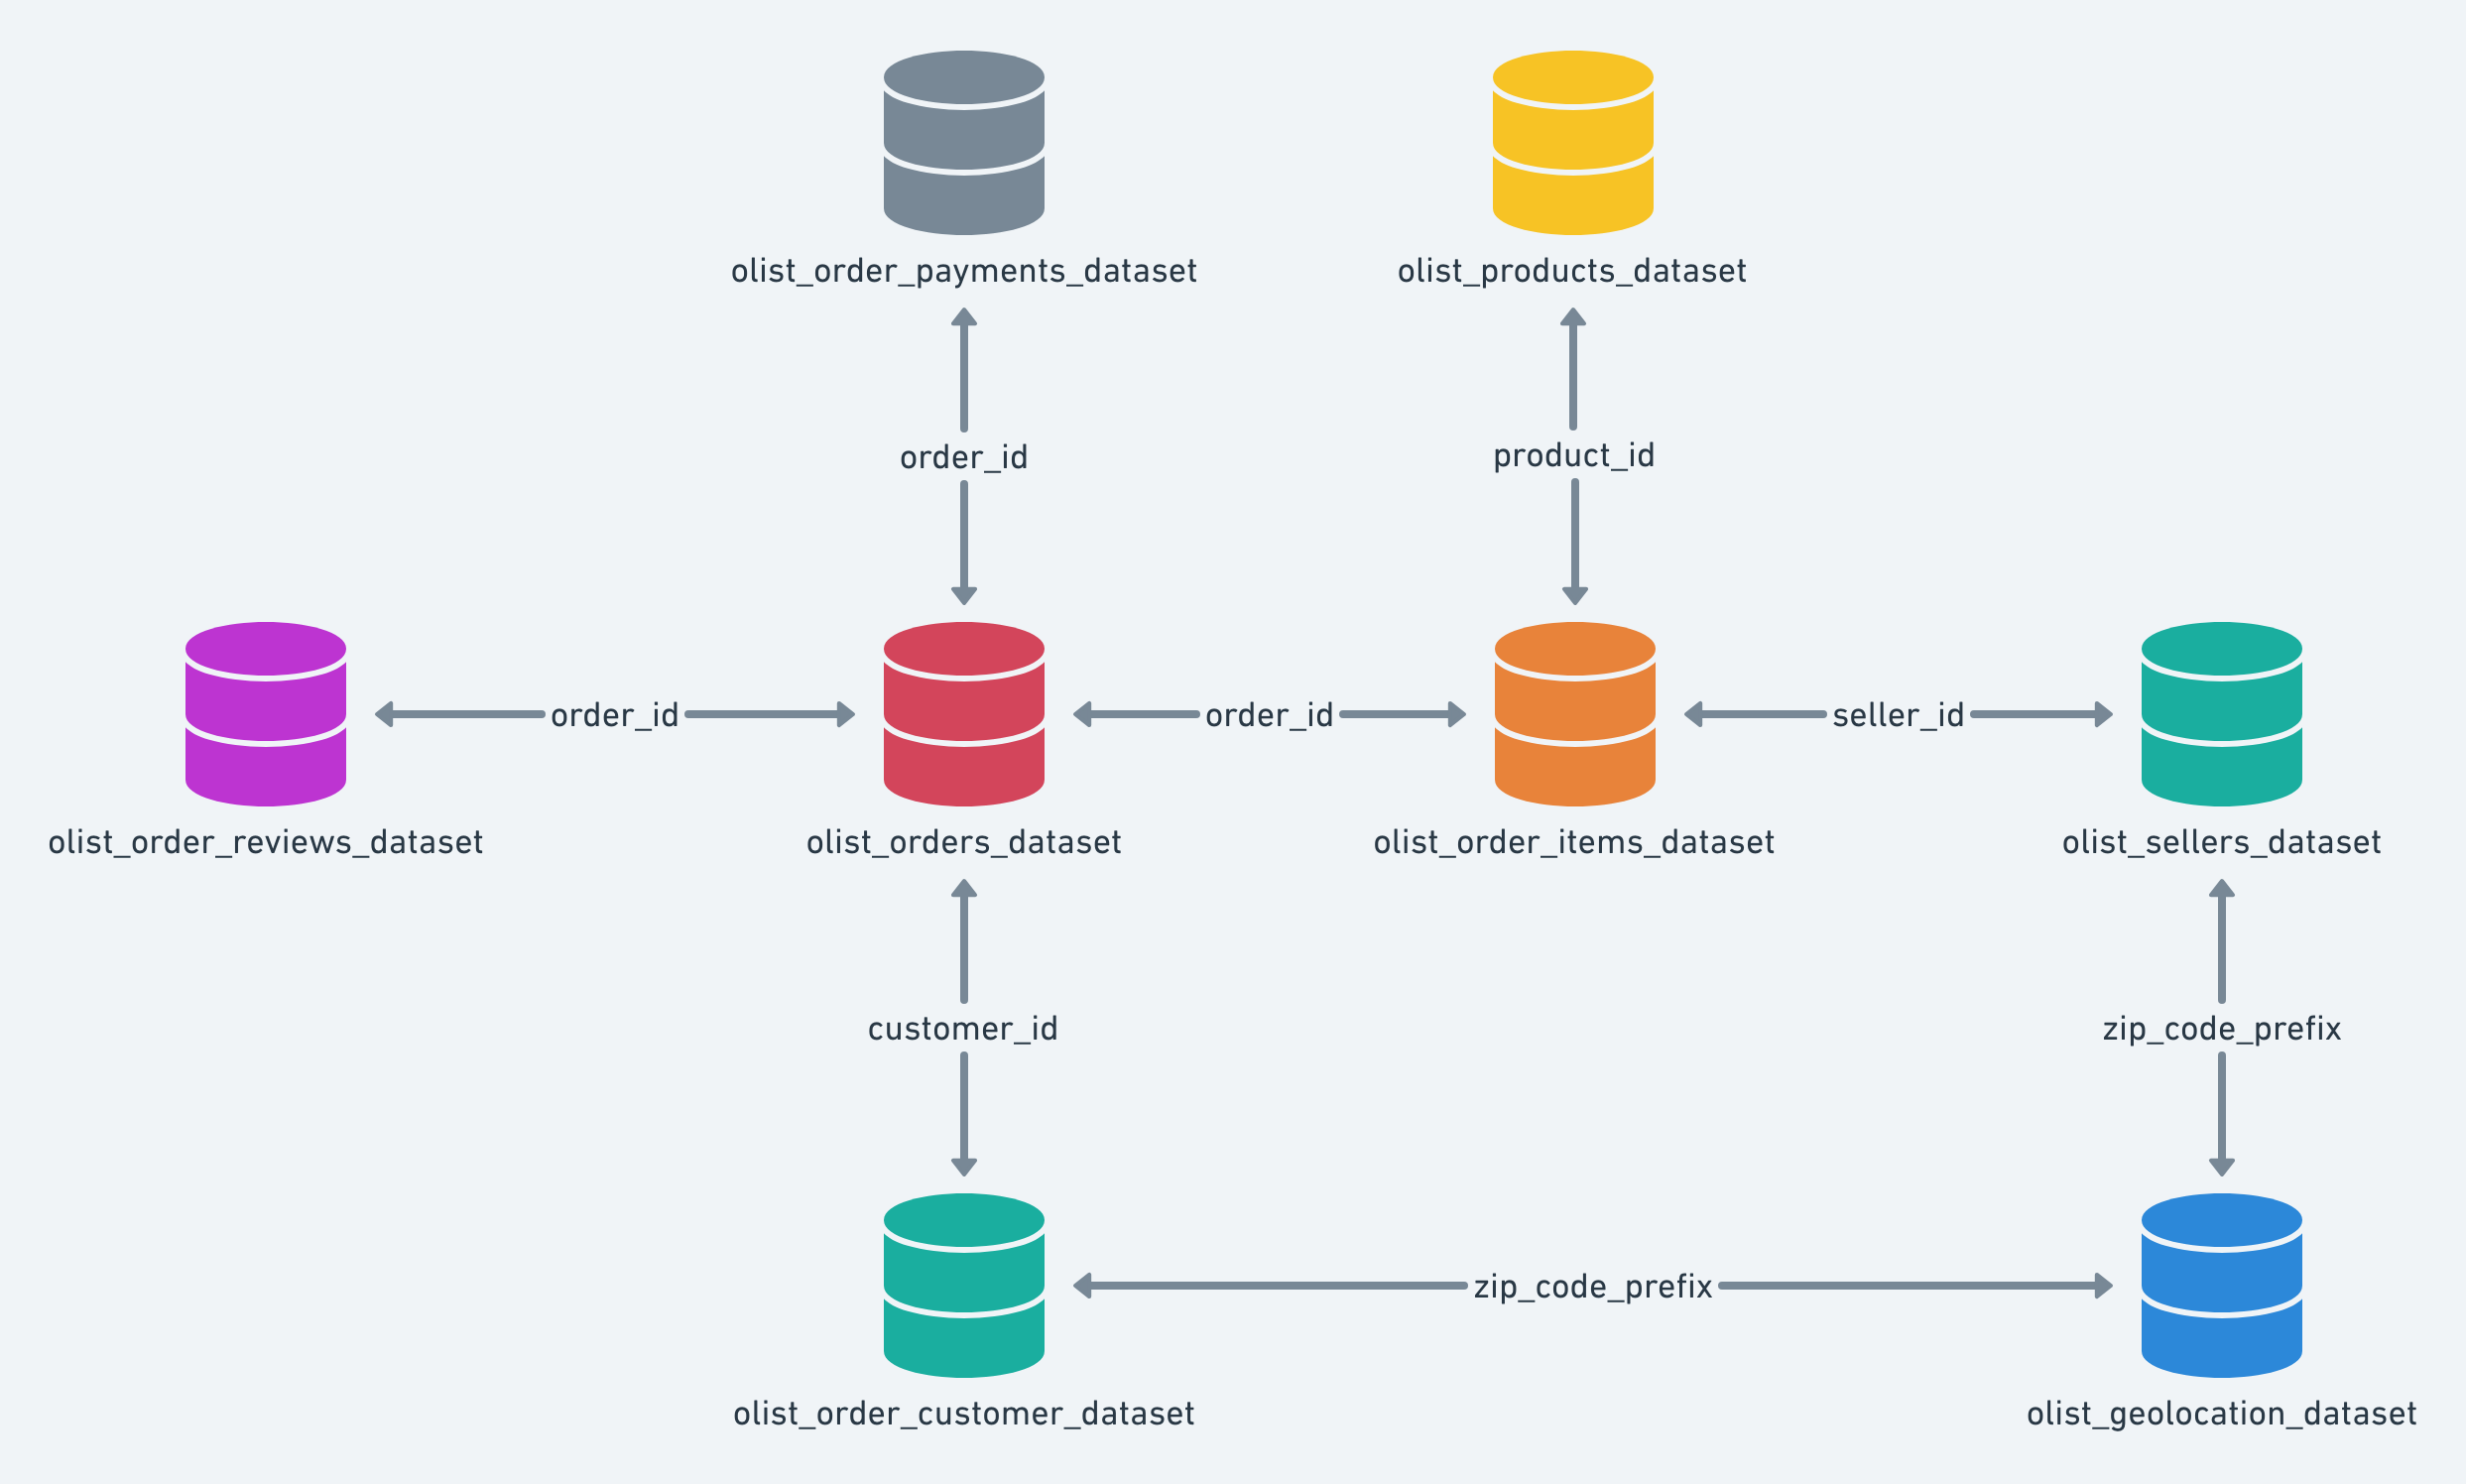

**Attention:** L'image dans le site de kaggle est légèrement différent des datasets que j'ai récupéré

# Fonctions utiles

## Affichage plus élégante du dataframe

Permet d'afficher le dataframe de tel sorte a ce qu'on puisse voir le plus de valeurs possibles (meilleur lisibilité).  
Affiche le nombre de lignes nécéssaires pour avoir au final au moins une valeur non nule pour chaque colonne.  

1) Si NbLignes(final_df) < 3 -> On lui rajoute 2 lignes les plus remplies de df  
2) Si NbLignes(final_df) >= 3 -> On ne fait rien   

L'objectif ici est d'avoir au moins 3 lignes d'affichage pour avoir une analyse pertinante des lignes et des colonnes

In [4]:
def ao(df):
    rows, columns = df.shape
    print("Nombre de lignes: ", rows)
    print("Nombre de colonnes: ", columns)

    filled_rows = df.dropna(how='all')  
    most_filled_row_index = filled_rows.notna().sum(axis=1).idxmax()  
    most_filled_row = filled_rows.loc[most_filled_row_index]  

    nan_columns = most_filled_row[most_filled_row.isna()].index
    other_rows = filled_rows.drop(most_filled_row_index)

    final_rows = [most_filled_row]

    for col in nan_columns:
        non_null_row = other_rows[other_rows[col].notna()].head(1)
        if not non_null_row.empty:
            final_rows.append(non_null_row.iloc[0])
            other_rows = other_rows.drop(non_null_row.index)

    final_df = pd.DataFrame(final_rows).reset_index(drop=True)

    # Ajouter des lignes les plus remplies de df si le nombre de lignes de final_df < 3
    if len(final_df) < 3:
        remaining_rows_needed = 3 - len(final_df)
        
        # Supprimer les lignes déjà présentes dans final_df en utilisant l'index d'origine
        original_indices = [row.name for row in final_rows]
        df_remaining = df.drop(original_indices, errors='ignore')
        
        sorted_remaining_rows = df_remaining.notna().sum(axis=1).sort_values(ascending=False)
        top_remaining_rows = sorted_remaining_rows.head(remaining_rows_needed).index
        additional_rows = df_remaining.loc[top_remaining_rows]
        final_df = pd.concat([final_df, additional_rows]).reset_index(drop=True)

    return final_df

## Plot valeur unique pour une colonne

Permet d'afficher un plot du % de représentation de chaque valeur unique dans une colonne spécifiée

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_percentage(column):
    # Calculez le pourcentage de chaque valeur unique dans la colonne
    value_counts = df[column].value_counts(normalize=True) * 100

    # Triez les données par pourcentage, de manière décroissante
    value_counts = value_counts.sort_values(ascending=True)

    # Créez un graphique à barres horizontales avec les pourcentages
    plt.figure(figsize=(10, 12))
    value_counts.plot(kind='barh', color='skyblue')

    # Ajoutez un titre et des labels pour les axes x et y
    plt.title('Pourcentage d\'apparence de chaque valeur dans la colonne "{}"'.format(column))
    plt.xlabel('Pourcentage (%)')
    plt.ylabel('Nom du produit')

    # Affichez le graphique
    plt.show()

## Recherche colonnes fortement corrélés

Des colonnes peuvent avoir le même role mais possédérer un nom différent, cette fonction cré une heatmap et nous donne des paires de colonnes possédant des corrélations linéaires supérieures ou égales à 95%

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def heatmap_correlation_colonnes(df, seuil_corr=0.95, figsize=(10, 8)):
    # Calculer la matrice de corrélation
    corr = df.corr(numeric_only=True)

    # Créer la heatmap
    fig, ax = plt.subplots(figsize=figsize)
    heatmap = sns.heatmap(corr, annot=True, fmt=".2f", ax=ax)

    # Incliner le texte des colonnes
    heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=55, ha='right')

    # Trouver les colonnes fortement corrélées
    correlated_pairs = []
    correlation_values = {}  # un dictionnaire pour stocker les valeurs de corrélation

    for i in range(len(corr.columns)):
        for j in range(i + 1, len(corr.columns)):
            if corr.iloc[i, j] >= seuil_corr:
                col1 = corr.columns[i]
                col2 = corr.columns[j]
                correlated_pairs.append((col1, col2))
                correlation_values[(col1, col2)] = corr.iloc[i, j]

    # Afficher les colonnes fortement corrélées et leurs valeurs de corrélation
    print("Les paires de colonnes fortement corrélées entre elles sont :")
    for pair in correlated_pairs:
        print(f"{pair[0]} et {pair[1]} : {correlation_values[pair]:.2f}")

    plt.show()

    return correlated_pairs, correlation_values

# Merging des datasets en une seule

In [7]:
import pandas as pd

# Fusion des dataframes
df = pd.merge(orders, order_reviews, on='order_id')
df = pd.merge(df, order_payments, on='order_id')
df = pd.merge(df, order_items, on='order_id')
df = pd.merge(df, customers, on='customer_id')
df = pd.merge(df, products, on='product_id')
df = pd.merge(df, sellers, on='seller_id')
df = pd.merge(df, translation, on='product_category_name')

In [8]:
ao(df)

Nombre de lignes:  115609
Nombre de colonnes:  40


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english
0,4382f48f29370e70ec4ef6aa3578e1c9,e5cede01799d43206f0e40fcfe683457,delivered,2018-07-29 21:59:48,2018-07-30 18:31:39,2018-07-31 06:14:00,2018-08-03 22:09:34,2018-08-10 00:00:00,1030f85adee4073399434a669c43f908,5,Pedido recebido corretame,O produto chegou até antes do prazo estipulado.,2018-08-04 00:00:00,2018-08-05 21:49:08,1,credit_card,7,79.76,1,883cea107372a7f07b5830904f74952d,1c40343cc5d18c2d8248ac2f3366de34,2018-08-01 15:55:18,64.99,14.77,59f5e5c0ff8a1ca7026faa8c316693eb,17900,dracena,SP,utilidades_domesticas,53.0,220.0,1.0,1125.0,36.0,43.0,36.0,13482,limeira,SP,housewares
1,c1a9b3fbea92e83c4a08229da82a0136,4e5570ae69c1badaab290766540ed0af,delivered,2018-08-01 17:27:04,2018-08-01 18:31:30,2018-08-03 12:39:00,2018-09-06 22:12:34,2018-08-21 00:00:00,e929ebcca7843cbdfcbf10d55cf0fd16,5,excelente,Super Recomendo!!!\r\nLoja Muito boa\r\nTive u...,2018-08-23 00:00:00,2018-09-10 22:17:01,1,credit_card,6,701.85,1,de89f330c497e12d2510c2cd2a48a29f,240b9776d844d37535668549a396af32,2018-08-09 17:35:18,679.00,22.85,2e3991c453b7a3b24907879771ac7818,39705,sao joao evangelista,MG,telefonia,30.0,900.0,1.0,605.0,16.0,14.0,16.0,24120,niteroi,RJ,telephony
2,1446ae966d68c3abad1ca3a3ce58033e,222e4c4d91c814cafc5badfe6a02c574,delivered,2018-04-27 15:52:45,2018-04-28 15:51:30,2018-05-15 07:40:00,2018-05-21 18:42:02,2018-05-30 00:00:00,0f5f44d33ec44594be4bfc882df31ce9,4,OK,OK,2018-05-22 00:00:00,2018-05-25 14:19:16,1,credit_card,5,1404.24,2,8ed094bfe076c568f6bb10feada3f75d,7c67e1448b00f6e969d365cea6b010ab,2018-05-14 15:51:30,175.90,58.14,fb98136edc2c0f996bfad36a0c7e1306,83414,colombo,PR,moveis_escritorio,43.0,1128.0,1.0,16133.0,63.0,59.0,25.0,8577,itaquaquecetuba,SP,office_furniture


In [9]:
geolocation[geolocation["geolocation_zip_code_prefix"] == 9350].head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
225654,9350,-23.680114,-46.452454,maua,SP
225660,9350,-23.675223,-46.441038,maua,SP
225680,9350,-23.685712,-46.444796,mauá,SP
225687,9350,-23.679951,-46.448247,maua,SP
225724,9350,-23.678662,-46.442578,maua,SP


Le dataframe geolocation ne va pas pouvoir nous servir car pour un même zip_code, on a plusieurs possibilités de latitude et de longitude -> Impossible à déterminer quoi correspondre au merged_df

# Cleaning

## Commandes livrées avec succès uniquement

In [10]:
import pandas as pd

# Compter le nombre d'occurrences de chaque valeur dans la colonne "order_status"
value_counts = df['order_status'].value_counts()

# Afficher les résultats
print(value_counts)

delivered      113210
shipped          1138
canceled          536
invoiced          358
processing        357
unavailable         7
approved            3
Name: order_status, dtype: int64


- 'delivered': Livrée avec succès
- 'shipped': Expédiée mais n'a pas encore été livrée.
- 'canceled': Aanulée par le client ou par le système
- 'invoiced': Facturée et est en attente de paiement
- 'processing': En cours de traitement et n'a pas encore été expédiée
- 'unavailable': L'article commandé n'est plus disponible
- 'approved': La commande a été approuvée et est prête à être traitée

**Seul "delivered" nous intéresse ici:**

In [11]:
print("Nombre de lignes avant la suppression :", df.shape[0])
df = df[df['order_status'] == 'delivered']
print("Nombre de lignes après la suppression :", df.shape[0])

Nombre de lignes avant la suppression : 115609
Nombre de lignes après la suppression : 113210


**On supprime maintenant la colonne "order_status" qui nous sert plus a rien**

In [12]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(["order_status"], axis=1)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 40
Nombre de colonnes après la suppression : 39


## Recherche NaN par colonnes

In [13]:
Nan_colonnes = df.isnull().sum().sort_values(ascending=False)
Nan_colonnes = Nan_colonnes[Nan_colonnes != 0]
Nan_colonnes

review_comment_title             99713
review_comment_message           65845
order_approved_at                   14
order_delivered_customer_date        8
order_delivered_carrier_date         2
product_height_cm                    1
product_width_cm                     1
product_length_cm                    1
product_weight_g                     1
dtype: int64

**Les colonnes "review_comment_title" et "review_comment_message" sont inutiles pour 3 raisons:**
- Ils sont facilement remplacables par le "review_score"
- Ils possèdent beaucoup trop de NaN
- Les messages sont en Portuguais...

In [14]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(["review_comment_title", "review_comment_message"], axis=1)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 39
Nombre de colonnes après la suppression : 37


**On va aussi supprimer les lignes ou on a du "NaN" dans les colonnes suivantes:**
- order_approved_at
- order_delivered_customer_date    
- order_delivered_carrier_date     
- product_length_cm                
- product_width_cm                 
- product_height_cm                
- product_weight_g                 

In [15]:
print("Nombre de lignes avant la suppression :", df.shape[0])
df.dropna(subset=["order_approved_at", "order_delivered_customer_date",
                 "order_delivered_carrier_date", "product_length_cm",
                 "product_width_cm", "product_height_cm",
                 "product_weight_g"], inplace=True)
print("Nombre de lignes après la suppression :", df.shape[0])

Nombre de lignes avant la suppression : 113210
Nombre de lignes après la suppression : 113186


In [16]:
Nan_colonnes = df.isnull().sum().sort_values(ascending=False)
Nan_colonnes = Nan_colonnes[Nan_colonnes != 0]
Nan_colonnes

Series([], dtype: int64)

## Colonnes inutiles

**"product_category_name" peut être remplacé par "product_category_name_english"**

In [17]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(["product_category_name"], axis=1)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 37
Nombre de colonnes après la suppression : 36


**La colonne "customer_id" est moins intéréssante que la colonne "customer_unique_id"**

In [18]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(["customer_id"], axis=1)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 36
Nombre de colonnes après la suppression : 35


**La colonne "payment_sequential" désigne l'ordre séquentiel des paiements -> Pas très intéréssant**

In [19]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(["payment_sequential"], axis=1)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 35
Nombre de colonnes après la suppression : 34


## Suppression lignes dupliqués

**On vérifie si on a des lignes dupliqués, si c'est le cas on les supprime**

In [20]:
print("Nombre de lignes avant la suppression :", df.shape[0])
df = df.drop_duplicates()
print("Nombre de lignes après la suppression :", df.shape[0])

Nombre de lignes avant la suppression : 113186
Nombre de lignes après la suppression : 112542


## Supression colonne "order_item_id"

**La colonne "order_item_id" ne sert pas à grand chose**

In [21]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(["order_item_id"], axis=1)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 34
Nombre de colonnes après la suppression : 33


## Supression quelque colonnes temps

**On peut supprimer "order_approved_at" et "order_delivered_carrier_date" car seuls les colonnes "order_delivered_customer_date", ""order_purchase_timestamp" et "order_estimated_delivery_date" nous intéresse**

In [22]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(["order_approved_at", "order_delivered_carrier_date"], axis=1)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 33
Nombre de colonnes après la suppression : 31


## Transformation colonne temps -> Nombre de secondes (format UNIX)

**Le format d'affichage des colonnes "order_delivered_customer_date", "order_estimated_delivery_date" et "review_answer_timestamp" nous sera plus utile dans un format en secondes**

In [23]:
df[df["order_id"] == "b5a801d2465c927e096449f176459916"]

,order_id,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_creation_date,review_answer_timestamp,payment_type,payment_installments,payment_value,product_id,seller_id,shipping_limit_date,price,freight_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english
3153,b5a801d2465c927e096449f176459916,2017-05-01 18:11:50,2017-05-23 12:32:22,2017-06-13 00:00:00,94b9eac694c93fb28d6e2fae6426cda9,5,2017-05-24 00:00:00,2017-05-25 08:47:55,credit_card,4,42.76,cb6d69daafeddab34122e1de88e1274c,8e6cc767478edae941d9bd9eb778d77a,2017-05-09 18:25:23,15.94,26.82,5ffbc70da7ad1808b6899421caa84fbe,50670,recife,PE,58.0,379.0,1.0,1850.0,25.0,21.0,21.0,38442,araguari,MG,housewares
3154,b5a801d2465c927e096449f176459916,2017-05-01 18:11:50,2017-05-23 12:32:22,2017-06-13 00:00:00,917a4b765108017eaac1d80971e8f1b7,4,2017-05-24 00:00:00,2017-05-25 08:48:42,credit_card,4,42.76,cb6d69daafeddab34122e1de88e1274c,8e6cc767478edae941d9bd9eb778d77a,2017-05-09 18:25:23,15.94,26.82,5ffbc70da7ad1808b6899421caa84fbe,50670,recife,PE,58.0,379.0,1.0,1850.0,25.0,21.0,21.0,38442,araguari,MG,housewares


In [24]:
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['review_answer_timestamp'] = pd.to_datetime(df['review_answer_timestamp'])

df['order_delivered_customer_date'] = (df['order_delivered_customer_date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
df['order_estimated_delivery_date'] = (df['order_estimated_delivery_date'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
df['review_answer_timestamp'] = (df['review_answer_timestamp'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

## Création colonne "delivery_lead_Time"

**Sera le produit de la soustraction entre le temps d'estimation et le temps de livraison, si cette valeur est positive c'est une bonne nouvelle, et ca sera négatif sinon**

In [25]:
print("Nombre de colonnes avant la création :", df.shape[1])
df['delivery_lead_Time'] = df['order_estimated_delivery_date'] - df['order_delivered_customer_date']
print("Nombre de colonnes après la création :", df.shape[1])

Nombre de colonnes avant la création : 31
Nombre de colonnes après la création : 32


## Supression colonne "order_estimated_delivery_date"

**Maintenant qu'on a "delivery_lead_Time" -> "order_estimated_delivery_date" ne sert plus à rien**

In [26]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(["order_estimated_delivery_date"], axis=1)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 32
Nombre de colonnes après la suppression : 31


## Supression colonne "shipping_limit_date"

**Cette colonne ne va pas nous donner d'informations intéréssantes sur les clients**

In [27]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(["shipping_limit_date"], axis=1)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 31
Nombre de colonnes après la suppression : 30


## Supression colonne "review_creation_date"

**Cette colonne ne va pas trop nous servir**

In [28]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(["review_creation_date"], axis=1)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 30
Nombre de colonnes après la suppression : 29


## Lignes ou on a plusieurs reviews pour le même order

Il peut arriver que le client fasse une review (avec un review_score) sur une commande qu'il a recu, et qu'après la réponse du "fournisseur", le client envoie une seconde review (avec un autre review_score)


In [29]:
unique_review_scores = df.groupby('order_id')['review_score'].nunique()

# Afficher les 'order_id' où le nombre de valeurs uniques de 'review_score' est supérieur à 1
multiple_scores = unique_review_scores[unique_review_scores > 1]

# Créer une liste des order_id qui ont plusieurs valeurs de review_score
order_ids = multiple_scores.index.tolist()

# Filtrer les lignes du dataframe en utilisant la liste des order_id
filtered_df = df[df['order_id'].isin(order_ids)]

filtered_df.head()

,order_id,order_purchase_timestamp,order_delivered_customer_date,review_id,review_score,review_answer_timestamp,payment_type,payment_installments,payment_value,product_id,seller_id,price,freight_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,delivery_lead_Time
2839,7a8345d4e981fc3d89b402f3e9978d15,2017-11-25 12:43:03,1512679742,7d2204d75ee1e09cd17e7f3dfa016954,1,1514458438,credit_card,5,65.00,081476f0ad46b45e23bbd0f3d1d4dd98,6edacfd9f9074789dad6d62ba7950b9c,49.90,15.10,248c6e95bd58d148fb635f18165484ce,99700,erechim,RS,43.0,554.0,2.0,175.0,16.0,12.0,12.0,7135,guarulhos,SP,housewares,1566658
2840,7a8345d4e981fc3d89b402f3e9978d15,2017-11-25 12:43:03,1512679742,e423065e21e53dc39fc63ff15d518358,5,1513077586,credit_card,5,65.00,081476f0ad46b45e23bbd0f3d1d4dd98,6edacfd9f9074789dad6d62ba7950b9c,49.90,15.10,248c6e95bd58d148fb635f18165484ce,99700,erechim,RS,43.0,554.0,2.0,175.0,16.0,12.0,12.0,7135,guarulhos,SP,housewares,1566658
2925,ee6830242df204d5290f7c4704464b56,2018-02-23 15:31:06,1520377755,ddfae824222583debd6fa7da6d4861af,1,1521721912,credit_card,2,74.07,20a5aefe5c61d9047acc46a0970e4908,f3da5b2ff499efb8d4a6d371d175d7dd,58.90,15.17,25b7b65257b6b18564ced68d89645225,30320,belo horizonte,MG,41.0,218.0,1.0,775.0,19.0,26.0,17.0,2407,sao paulo,SP,housewares,694245
2926,ee6830242df204d5290f7c4704464b56,2018-02-23 15:31:06,1520377755,2e73b38ee1d433671908a0ff6625bfa1,4,1520607109,credit_card,2,74.07,20a5aefe5c61d9047acc46a0970e4908,f3da5b2ff499efb8d4a6d371d175d7dd,58.90,15.17,25b7b65257b6b18564ced68d89645225,30320,belo horizonte,MG,41.0,218.0,1.0,775.0,19.0,26.0,17.0,2407,sao paulo,SP,housewares,694245
3153,b5a801d2465c927e096449f176459916,2017-05-01 18:11:50,1495542742,94b9eac694c93fb28d6e2fae6426cda9,5,1495702075,credit_card,4,42.76,cb6d69daafeddab34122e1de88e1274c,8e6cc767478edae941d9bd9eb778d77a,15.94,26.82,5ffbc70da7ad1808b6899421caa84fbe,50670,recife,PE,58.0,379.0,1.0,1850.0,25.0,21.0,21.0,38442,araguari,MG,housewares,1769258


**On ne va garder uniquement que les reviews les plus récentes dans cette situation**

In [30]:
print("Nombre de lignes avant la suppression :", df.shape[0])
# Créer un groupe par 'order_id' et obtenir le nombre de 'product_id' uniques
grouped = df.groupby('order_id')['product_id'].nunique()

# Trouver les 'order_id' qui ont plus d'un 'product_id' unique
order_ids_with_multiple_products = grouped[grouped > 1].index

# Filtre pour garder les lignes où 'order_id' a plus d'un 'product_id' unique
df_multiple_products = df[df['order_id'].isin(order_ids_with_multiple_products)]

# Pour les 'order_id' restants, trier et supprimer les doublons
df_remaining = df[~df['order_id'].isin(order_ids_with_multiple_products)]
df_remaining = df_remaining.sort_values(['order_id', 'review_answer_timestamp'])
df_remaining = df_remaining.drop_duplicates(subset='order_id', keep='last')

# Concaténer les deux DataFrame pour obtenir le résultat final
df = pd.concat([df_multiple_products, df_remaining])

print("Nombre de lignes après la suppression :", df.shape[0])

Nombre de lignes avant la suppression : 112542
Nombre de lignes après la suppression : 99227


## Supression colonne review_answer_timestamp

Elle ne sert plus à rien maintenant 

In [31]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(["review_answer_timestamp"], axis=1)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 29
Nombre de colonnes après la suppression : 28


In [32]:
df[df["order_id"] == "5f49f31e537f8f1a496454b48edbe34d"]

,order_id,order_purchase_timestamp,order_delivered_customer_date,review_id,review_score,payment_type,payment_installments,payment_value,product_id,seller_id,price,freight_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english,delivery_lead_Time
6,5f49f31e537f8f1a496454b48edbe34d,2017-08-24 11:31:28,1503951140,8899ca945efd951c97107b4966289227,1,credit_card,1,127.45,be03d93320192443b8fa24c0ca6ead98,3504c0cb71d7fa48d967e0e4c94d59d9,46.8,67.70,7a1de9bde89aedca8c5fbad489c5571c,1315,sao paulo,SP,59.0,189.0,3.0,775.0,16.0,16.0,13.0,9350,maua,SP,housewares,1396060
6587,5f49f31e537f8f1a496454b48edbe34d,2017-08-24 11:31:28,1503951140,8899ca945efd951c97107b4966289227,1,credit_card,1,127.45,d4a3b5aa064bf44e74f1e71862bea22a,57c764b4a836300be881e2ff86e449f9,9.9,3.05,7a1de9bde89aedca8c5fbad489c5571c,1315,sao paulo,SP,59.0,236.0,1.0,100.0,21.0,9.0,13.0,14021,ribeirao preto,SP,housewares,1396060


# Supression "product_name_lenght" et "product_description_lenght"

- **product_name_length:** Longueur du nom du produit
- **product_description_length:** Longueur de la description du produit

N'ont pas une grande utilité dans le contexte actuel

In [33]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(["product_name_lenght", "product_description_lenght"], axis=1)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 28
Nombre de colonnes après la suppression : 26


# Création deux fichiers csv distincts

On va devoir créer deux fichiers csv pour une utilisation différente:
- **data_cleaned.csv** -> Servira pour des algorithmes de clustering classique (k-means, DBScan...)
- **data_cleaned_rfm.csv** -> Servira pour la segmentation RFM (Récence, Fréquence, Valeur Monétaire)

## 1# Création csv RFM

On aura besoin d'abord uniquement des colonnes suivantes:
- "customer_unique_id"
- "order_id"
- "product_id"
- "order_purchase_timestamp"
- "payment_value"

In [34]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df_rfm = df.loc[:, ["customer_unique_id", "order_id", "product_id", "order_purchase_timestamp", "payment_value"]].copy()
print("Nombre de colonnes après la suppression :", df_rfm.shape[1])

Nombre de colonnes avant la suppression : 26
Nombre de colonnes après la suppression : 5


In [35]:
df_rfm[df_rfm["order_id"] == "5f49f31e537f8f1a496454b48edbe34d"]

,customer_unique_id,order_id,product_id,order_purchase_timestamp,payment_value
6,7a1de9bde89aedca8c5fbad489c5571c,5f49f31e537f8f1a496454b48edbe34d,be03d93320192443b8fa24c0ca6ead98,2017-08-24 11:31:28,127.45
6587,7a1de9bde89aedca8c5fbad489c5571c,5f49f31e537f8f1a496454b48edbe34d,d4a3b5aa064bf44e74f1e71862bea22a,2017-08-24 11:31:28,127.45


On se rend compte que pour un une valeur dans "order_id", on peut avoir plusieurs "product_id"  
**On va faire en sorte de n'avoir qu'un seul product_id par order_id (car le payement_value est le total de tout les product_id)**

In [36]:
print("Nombre de lignes avant la suppression :", df_rfm.shape[0])
df_rfm = df_rfm.drop_duplicates(subset='order_id', keep='first')
print("Nombre de lignes après la suppression :", df_rfm.shape[0])

Nombre de lignes avant la suppression : 99227
Nombre de lignes après la suppression : 94465


In [37]:
df_rfm[df_rfm["order_id"] == "5f49f31e537f8f1a496454b48edbe34d"]

,customer_unique_id,order_id,product_id,order_purchase_timestamp,payment_value
6,7a1de9bde89aedca8c5fbad489c5571c,5f49f31e537f8f1a496454b48edbe34d,be03d93320192443b8fa24c0ca6ead98,2017-08-24 11:31:28,127.45


**On va supprimer les colonnes  "order_id" et "product_id" qui ne vont plus nous servir**

In [38]:
print("Nombre de colonnes avant la suppression :", df_rfm.shape[1])
df_rfm = df_rfm.drop(["order_id", "product_id"], axis=1)
print("Nombre de colonnes après la suppression :", df_rfm.shape[1])

Nombre de colonnes avant la suppression : 5
Nombre de colonnes après la suppression : 3


In [39]:
df_rfm[df_rfm["customer_unique_id"] == "7a1de9bde89aedca8c5fbad489c5571c"]

,customer_unique_id,order_purchase_timestamp,payment_value
6,7a1de9bde89aedca8c5fbad489c5571c,2017-08-24 11:31:28,127.45
52529,7a1de9bde89aedca8c5fbad489c5571c,2017-12-02 15:16:36,339.55


**On transforme notre dataset plus ne plus avoir que les colonnes "recency", "frequency" et "monetary_value"**
- Pour la Récence, nous utiliserons la date de l'achat le plus récent + 1 jour

In [40]:
from datetime import timedelta
print("Nombre de lignes avant la suppression :", df_rfm.shape[0])
# Convert order_purchase_timestamp to datetime
df_rfm['order_purchase_timestamp'] = pd.to_datetime(df_rfm['order_purchase_timestamp'])

# Define "now" as the latest timestamp in the data plus one day
now = df_rfm['order_purchase_timestamp'].max() + timedelta(days=1)

# Group by customer_unique_id and calculate Recency, Frequency and Monetary value
df_rfm = df_rfm.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (now - x.max()).days,  # Recency
    'customer_unique_id': 'count',  # Frequency
    'payment_value': 'sum'  # Monetary Value
})

# Rename the columns
df_rfm.rename(columns={
    'order_purchase_timestamp': 'recency',
    'customer_unique_id': 'frequency',
    'payment_value': 'monetary_value'
}, inplace=True)

# Now we can reset the index
df_rfm.reset_index(inplace=True)
print("Nombre de lignes après la suppression :", df_rfm.shape[0])

Nombre de lignes avant la suppression : 94465
Nombre de lignes après la suppression : 91459


In [41]:
df_rfm.head()

,customer_unique_id,recency,frequency,monetary_value
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,27.19
2,0000f46a3911fa3c0805444483337064,537,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,288,1,196.89


In [42]:
unique_values = df_rfm['frequency'].unique()
print(unique_values)

[ 1  2  3  4  6  7  5  9 14]


## 2# Création csv classique

### Supression colonne "order_purchase_timestamp"

Elle a servi pour la segmentation RFM mais pour faire un k-means par exemple on en aura pas forcément besoin

In [43]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(["order_purchase_timestamp"], axis=1)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 26
Nombre de colonnes après la suppression : 25


### One-hot encoder sur certainnes colonnes

Les colonnes suceptibles d'avoir du one hot encoder sont celles ci:
- payment_type
- customer_zip_code_prefix
- customer_city
- customer_state
- seller_zip_code_prefix
- seller_city	
- seller_state
- product_category_name_english	

In [44]:
# Liste des colonnes qui vous intéressent
cols_to_consider = [
    "payment_type", 
    "customer_zip_code_prefix", 
    "customer_city", 
    "customer_state", 
    "seller_zip_code_prefix", 
    "seller_city", 
    "seller_state", 
    "product_category_name_english"
]

# Création d'un nouveau DataFrame à partir du nombre de valeurs uniques dans chaque colonne
unique_counts = pd.DataFrame(df[cols_to_consider].nunique(), columns=['Number_of_unique_values'])
unique_counts_sorted = unique_counts.sort_values(by='Number_of_unique_values', ascending=False)
unique_counts_sorted

,Number_of_unique_values
customer_zip_code_prefix,14825
customer_city,4071
seller_zip_code_prefix,2133
seller_city,587
product_category_name_english,71
customer_state,27
seller_state,22
payment_type,4


Ces colonnes vont être supprimés, elles augmentent beaucoup trop la dimensionalité du dataset:
- customer_zip_code_prefix
- seller_zip_code_prefix
- customer_city
- seller_city  

On peut se permettre de les supprimer car "state" est une information de localisation comme "city" et "zip_code" (même si "state" est moins précis)

In [45]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(["customer_zip_code_prefix", "seller_zip_code_prefix", "customer_city", "seller_city"], axis=1)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 25
Nombre de colonnes après la suppression : 21


**Avant d'effectuer du one-hot encoding, on peut regarder la répartition des valeurs des 4 autres colonnes:**

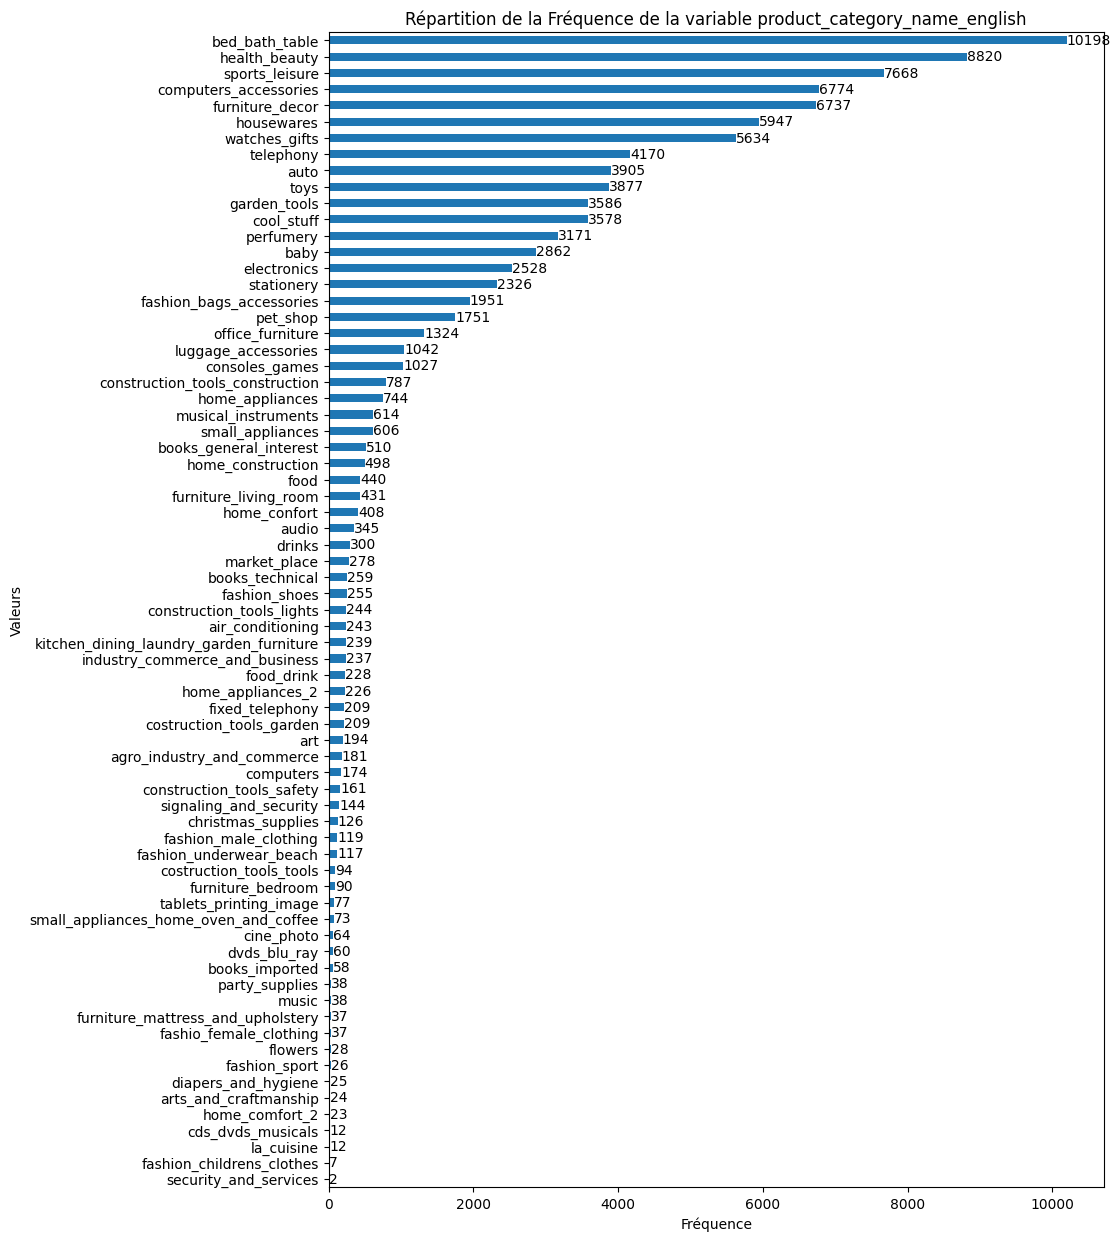

In [46]:
import matplotlib.pyplot as plt

# Obtenir le décompte des catégories de produits et les trier par ordre décroissant
category_counts = df['product_category_name_english'].value_counts().sort_values(ascending=True)

# Créer une figure avec une taille personnalisée
plt.figure(figsize=(10, 15))

# Créer le graphique à barres avec les axes inversés
ax = category_counts.plot(kind='barh')

# Ajouter les annotations
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width(), p.get_y() + p.get_height() / 2), ha='left', va='center')

# Ajouter les titres et labels
plt.title('Répartition de la Fréquence de la variable ' + df['product_category_name_english'].name)
plt.xlabel('Fréquence')
plt.ylabel('Valeurs')
plt.show()


**Les articles de (literie + salle de bains + table) sont les plus représentés**

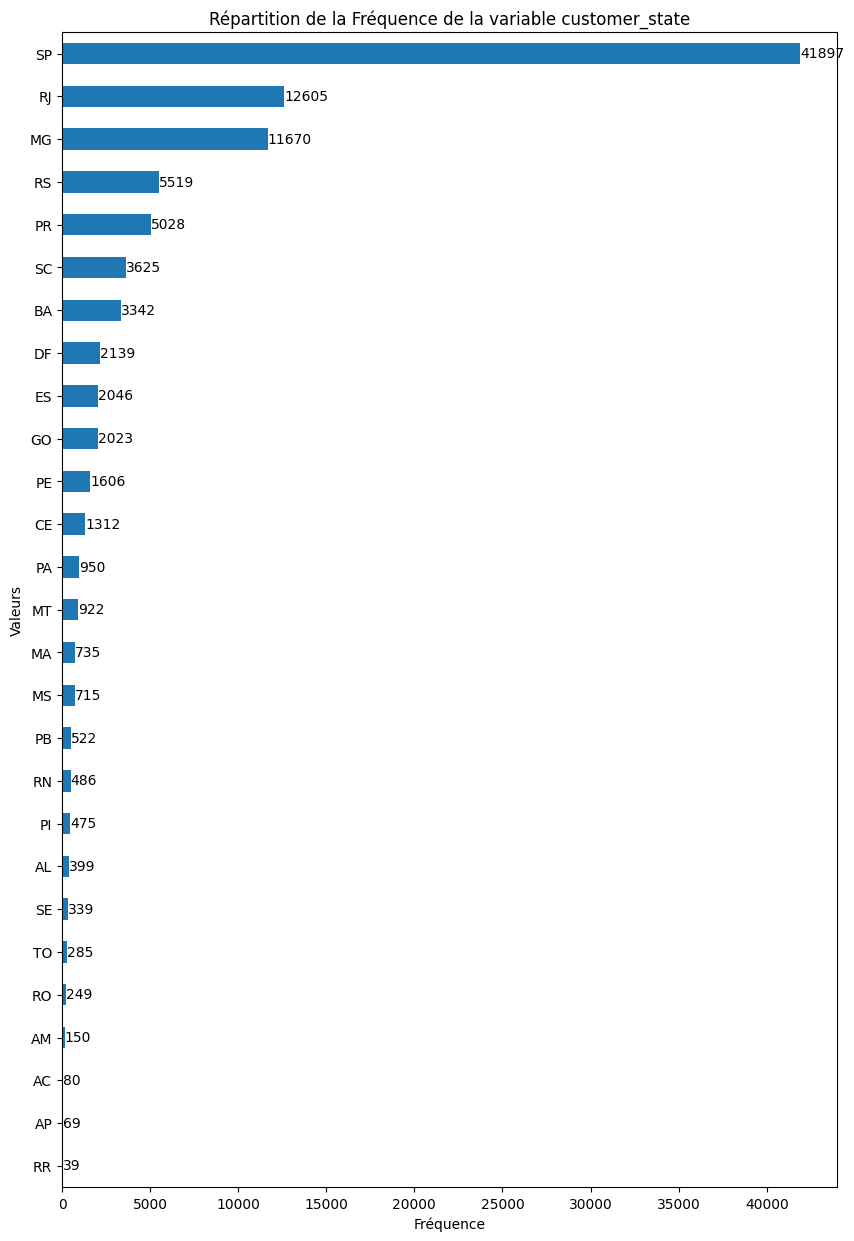

In [47]:
import matplotlib.pyplot as plt

# Obtenir le décompte des catégories de produits et les trier par ordre décroissant
category_counts = df['customer_state'].value_counts().sort_values(ascending=True)

# Créer une figure avec une taille personnalisée
plt.figure(figsize=(10, 15))

# Créer le graphique à barres avec les axes inversés
ax = category_counts.plot(kind='barh')

# Ajouter les annotations
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width(), p.get_y() + p.get_height() / 2), ha='left', va='center')

# Ajouter les titres et labels
plt.title('Répartition de la Fréquence de la variable ' + df['customer_state'].name)
plt.xlabel('Fréquence')
plt.ylabel('Valeurs')
plt.show()

**L'état de São Paulo est le plus représenté pour les clients**

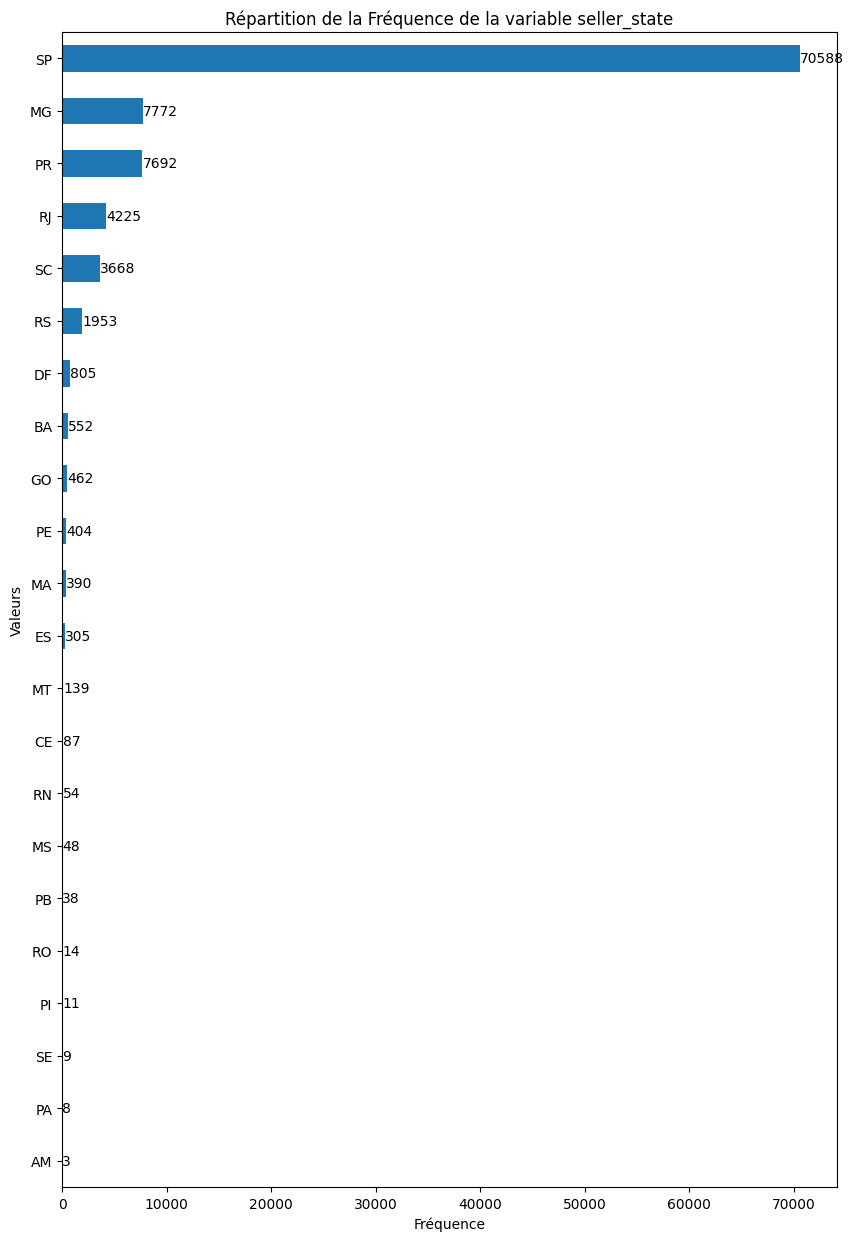

In [48]:
import matplotlib.pyplot as plt

# Obtenir le décompte des catégories de produits et les trier par ordre décroissant
category_counts = df['seller_state'].value_counts().sort_values(ascending=True)

# Créer une figure avec une taille personnalisée
plt.figure(figsize=(10, 15))

# Créer le graphique à barres avec les axes inversés
ax = category_counts.plot(kind='barh')

# Ajouter les annotations
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width(), p.get_y() + p.get_height() / 2), ha='left', va='center')

# Ajouter les titres et labels
plt.title('Répartition de la Fréquence de la variable ' + df['seller_state'].name)
plt.xlabel('Fréquence')
plt.ylabel('Valeurs')
plt.show()

**L'état de São Paulo est le plus représenté pour les vendeurs**

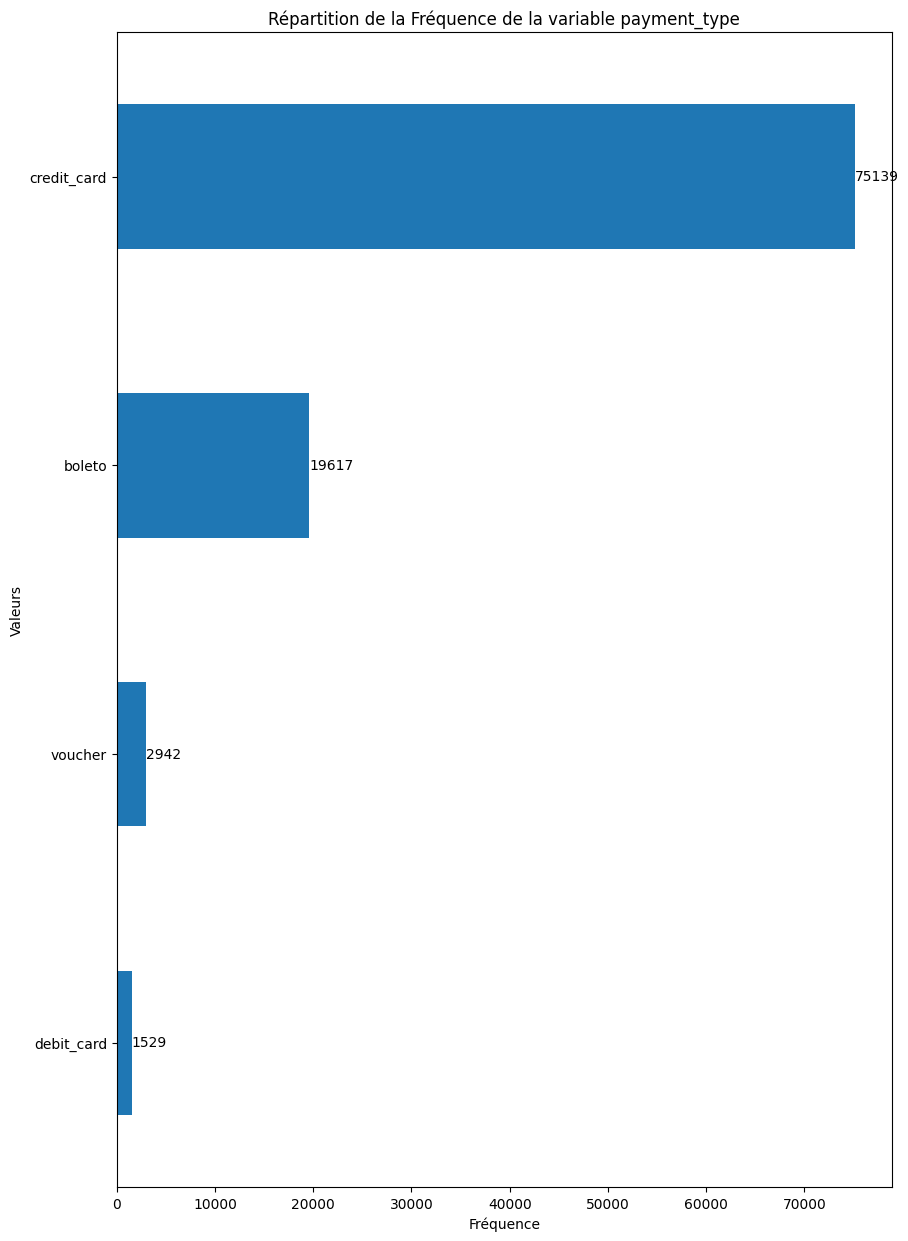

In [49]:
import matplotlib.pyplot as plt

# Obtenir le décompte des catégories de produits et les trier par ordre décroissant
category_counts = df['payment_type'].value_counts().sort_values(ascending=True)

# Créer une figure avec une taille personnalisée
plt.figure(figsize=(10, 15))

# Créer le graphique à barres avec les axes inversés
ax = category_counts.plot(kind='barh')

# Ajouter les annotations
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width(), p.get_y() + p.get_height() / 2), ha='left', va='center')

# Ajouter les titres et labels
plt.title('Répartition de la Fréquence de la variable ' + df['payment_type'].name)
plt.xlabel('Fréquence')
plt.ylabel('Valeurs')
plt.show()

**La carte de crédit est le mode de paiement le plus utilisé**

**On va procéder maintenant au one-hot encoding:**

In [50]:
import pandas as pd

def one_hot(df, column_name):
    return pd.get_dummies(df, columns=[column_name])

In [51]:
print("Nombre de colonnes avant l'encodage :", df.shape[1])
df = one_hot(df, "product_category_name_english")
print("Nombre de colonnes après l'encodage :", df.shape[1])

Nombre de colonnes avant l'encodage : 21
Nombre de colonnes après l'encodage : 91


In [52]:
print("Nombre de colonnes avant l'encodage :", df.shape[1])
df = one_hot(df, "customer_state")
print("Nombre de colonnes après l'encodage :", df.shape[1])

Nombre de colonnes avant l'encodage : 91
Nombre de colonnes après l'encodage : 117


In [53]:
print("Nombre de colonnes avant l'encodage :", df.shape[1])
df = one_hot(df, "seller_state")
print("Nombre de colonnes après l'encodage :", df.shape[1])

Nombre de colonnes avant l'encodage : 117
Nombre de colonnes après l'encodage : 138


In [54]:
print("Nombre de colonnes avant l'encodage :", df.shape[1])
df = one_hot(df, "payment_type")
print("Nombre de colonnes après l'encodage :", df.shape[1])

Nombre de colonnes avant l'encodage : 138
Nombre de colonnes après l'encodage : 141


## Supression de certaines colonnes id

review_id et seller_id ne vont pas nous servir à grand chose

In [55]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(["review_id", "seller_id"], axis=1)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 141
Nombre de colonnes après la suppression : 139


### Regroupement des lignes product_id

Par cet exemple on remarque sur pour une valeur "customer_unique_id" choisi, on peut avoir plusieurs produits sur un même order.  
Ce qui change entre 2 lignes ayant le même "customer_unique_id" et "order_id" mais un "product_id" différent sont ces colonnes:
- "order_id" (keep "first")
- "order_delivered_customer_date (Moyenne)
- "review_score" (Moyenne)
- "payment_installments" (Moyenne)
- "product_id" (Keep "first")
- "price" (Additionner)
- "freight_value" (Additionner)
- "customer_unique_id" (keep "first")
- "product_photos_qty" (Moyenne)
- "product_length_cm" (Moyenne)
- "product_height_cm" (Moyenne)
- "product_width_cm" (Moyenne)
- "delivery_lead_Time" (Moyenne)
- Le reste (Operation max)

In [56]:
print("Nombre de lignes avant la suppression :", df.shape[0])
df_columns = set(df.columns)
defined_columns = set([
    'customer_unique_id', 'order_id', 'order_delivered_customer_date',
    'review_score', 'payment_installments', 'product_id', 'price',
    'product_photos_qty', 'product_length_cm', 'product_height_cm',
    'product_width_cm', 'freight_value', 'delivery_lead_Time'
])

remaining_columns = df_columns - defined_columns

agg_operations = {
    'order_delivered_customer_date': 'mean',
    'review_score': 'mean',
    'payment_installments': 'mean',
    'product_id': 'first',
    'price': 'sum',
    'product_photos_qty': 'mean',
    'product_length_cm': 'mean',
    'product_height_cm': 'mean',
    'product_width_cm': 'mean',
    'freight_value': 'sum',
    'delivery_lead_Time': 'mean'
}

# Pour les colonnes restantes, ajoutez-les à la fonction 'agg' avec l'opération 'max'
for column in remaining_columns:
    agg_operations[column] = 'max'

df = df.groupby(['customer_unique_id', 'order_id']).agg(agg_operations).reset_index()
print("Nombre de lignes après la suppression :", df.shape[0])

Nombre de lignes avant la suppression : 99227
Nombre de lignes après la suppression : 94465


### Regroupement des lignes order_id

On fait désormais la même chose en regroupant selon "order_id" car un client peut avoir plusieurs commandes

In [57]:
df[df["customer_unique_id"] == "0aa1ab39ff2b837c05d7c9ff85b6d983"]

,customer_unique_id,order_id,order_delivered_customer_date,review_score,payment_installments,product_id,price,product_photos_qty,product_length_cm,product_height_cm,product_width_cm,freight_value,delivery_lead_Time,product_category_name_english_market_place,seller_state_DF,customer_state_RR,product_category_name_english_watches_gifts,product_category_name_english_consoles_games,product_category_name_english_furniture_living_room,seller_state_SE,customer_state_AC,product_category_name_english_office_furniture,product_category_name_english_construction_tools_lights,product_category_name_english_electronics,product_category_name_english_stationery,product_category_name_english_audio,customer_state_MS,product_category_name_english_agro_industry_and_commerce,product_category_name_english_diapers_and_hygiene,product_category_name_english_perfumery,customer_state_TO,seller_state_RO,payment_value,product_category_name_english_air_conditioning,customer_state_RO,product_category_name_english_books_technical,product_category_name_english_musical_instruments,seller_state_MT,product_category_name_english_security_and_services,customer_state_PA,payment_type_debit_card,customer_state_GO,seller_state_PI,product_category_name_english_bed_bath_table,product_category_name_english_tablets_printing_image,customer_state_BA,product_category_name_english_telephony,seller_state_PR,product_category_name_english_pet_shop,customer_state_AP,customer_state_SP,product_category_name_english_sports_leisure,product_category_name_english_baby,customer_state_AM,product_category_name_english_small_appliances_home_oven_and_coffee,customer_state_RN,seller_state_SC,product_category_name_english_housewares,product_category_name_english_furniture_decor,product_category_name_english_construction_tools_safety,product_category_name_english_arts_and_craftmanship,customer_state_PB,customer_state_SC,product_category_name_english_signaling_and_security,product_category_name_english_costruction_tools_garden,product_category_name_english_la_cuisine,seller_state_AM,seller_state_SP,customer_state_MT,product_category_name_english_flowers,product_category_name_english_fixed_telephony,product_category_name_english_fashion_underwear_beach,product_category_name_english_furniture_mattress_and_upholstery,seller_state_BA,product_category_name_english_construction_tools_construction,product_category_name_english_home_appliances_2,product_category_name_english_fashion_sport,product_category_name_english_home_appliances,product_category_name_english_party_supplies,product_category_name_english_fashion_male_clothing,product_category_name_english_fashion_bags_accessories,product_category_name_english_toys,customer_state_AL,customer_state_MG,product_category_name_english_industry_commerce_and_business,product_category_name_english_home_construction,product_category_name_english_luggage_accessories,seller_state_PE,product_category_name_english_cine_photo,customer_state_PI,customer_state_SE,product_category_name_english_art,customer_state_ES,product_category_name_english_christmas_supplies,customer_state_CE,product_category_name_english_drinks,product_category_name_english_music,seller_state_RJ,product_category_name_english_health_beauty,product_category_name_english_kitchen_dining_laundry_garden_furniture,customer_state_MA,seller_state_ES,payment_type_voucher,customer_state_RJ,product_category_name_english_home_confort,product_category_name_english_cds_dvds_musicals,product_category_name_english_books_general_interest,product_category_name_english_books_imported,payment_type_boleto,product_category_name_english_small_appliances,product_category_name_english_fashion_childrens_clothes,product_category_name_english_food,product_category_name_english_auto,customer_state_DF,seller_state_RN,seller_state_MS,product_category_name_english_fashion_shoes,product_category_name_english_home_comfort_2,product_category_name_english_fashio_female_clothing,product_weight_g,seller_state_GO,product_category_name

In [58]:
df[df["customer_unique_id"] == "7a1de9bde89aedca8c5fbad489c5571c"]

,customer_unique_id,order_id,order_delivered_customer_date,review_score,payment_installments,product_id,price,product_photos_qty,product_length_cm,product_height_cm,product_width_cm,freight_value,delivery_lead_Time,product_category_name_english_market_place,seller_state_DF,customer_state_RR,product_category_name_english_watches_gifts,product_category_name_english_consoles_games,product_category_name_english_furniture_living_room,seller_state_SE,customer_state_AC,product_category_name_english_office_furniture,product_category_name_english_construction_tools_lights,product_category_name_english_electronics,product_category_name_english_stationery,product_category_name_english_audio,customer_state_MS,product_category_name_english_agro_industry_and_commerce,product_category_name_english_diapers_and_hygiene,product_category_name_english_perfumery,customer_state_TO,seller_state_RO,payment_value,product_category_name_english_air_conditioning,customer_state_RO,product_category_name_english_books_technical,product_category_name_english_musical_instruments,seller_state_MT,product_category_name_english_security_and_services,customer_state_PA,payment_type_debit_card,customer_state_GO,seller_state_PI,product_category_name_english_bed_bath_table,product_category_name_english_tablets_printing_image,customer_state_BA,product_category_name_english_telephony,seller_state_PR,product_category_name_english_pet_shop,customer_state_AP,customer_state_SP,product_category_name_english_sports_leisure,product_category_name_english_baby,customer_state_AM,product_category_name_english_small_appliances_home_oven_and_coffee,customer_state_RN,seller_state_SC,product_category_name_english_housewares,product_category_name_english_furniture_decor,product_category_name_english_construction_tools_safety,product_category_name_english_arts_and_craftmanship,customer_state_PB,customer_state_SC,product_category_name_english_signaling_and_security,product_category_name_english_costruction_tools_garden,product_category_name_english_la_cuisine,seller_state_AM,seller_state_SP,customer_state_MT,product_category_name_english_flowers,product_category_name_english_fixed_telephony,product_category_name_english_fashion_underwear_beach,product_category_name_english_furniture_mattress_and_upholstery,seller_state_BA,product_category_name_english_construction_tools_construction,product_category_name_english_home_appliances_2,product_category_name_english_fashion_sport,product_category_name_english_home_appliances,product_category_name_english_party_supplies,product_category_name_english_fashion_male_clothing,product_category_name_english_fashion_bags_accessories,product_category_name_english_toys,customer_state_AL,customer_state_MG,product_category_name_english_industry_commerce_and_business,product_category_name_english_home_construction,product_category_name_english_luggage_accessories,seller_state_PE,product_category_name_english_cine_photo,customer_state_PI,customer_state_SE,product_category_name_english_art,customer_state_ES,product_category_name_english_christmas_supplies,customer_state_CE,product_category_name_english_drinks,product_category_name_english_music,seller_state_RJ,product_category_name_english_health_beauty,product_category_name_english_kitchen_dining_laundry_garden_furniture,customer_state_MA,seller_state_ES,payment_type_voucher,customer_state_RJ,product_category_name_english_home_confort,product_category_name_english_cds_dvds_musicals,product_category_name_english_books_general_interest,product_category_name_english_books_imported,payment_type_boleto,product_category_name_english_small_appliances,product_category_name_english_fashion_childrens_clothes,product_category_name_english_food,product_category_name_english_auto,customer_state_DF,seller_state_RN,seller_state_MS,product_category_name_english_fashion_shoes,product_category_name_english_home_comfort_2,product_category_name_english_fashio_female_clothing,product_weight_g,seller_state_GO,product_category_name

In [59]:
print("Nombre de lignes avant la suppression :", df.shape[0])
df_columns = set(df.columns)
defined_columns = set([
    'customer_unique_id', 'order_id', 'order_delivered_customer_date',
    'review_score', 'payment_installments', 'product_id', 'price',
    'product_photos_qty', 'product_length_cm', 'product_height_cm',
    'product_width_cm', 'freight_value', 'delivery_lead_Time', 'payment_value'
])

remaining_columns = df_columns - defined_columns

agg_operations = {
    'order_delivered_customer_date': 'mean',
    'review_score': 'mean',
    'payment_installments': 'mean',
    'product_id': 'first',
    'price': 'sum',
    'product_photos_qty': 'mean',
    'product_length_cm': 'mean',
    'product_height_cm': 'mean',
    'product_width_cm': 'mean',
    'freight_value': 'sum',
    'delivery_lead_Time': 'mean',
    'payment_value': 'sum',
    'order_id': 'first'  # ajouter cette ligne pour conserver 'order_id'
}

# Pour les colonnes restantes, ajoutez-les à la fonction 'agg' avec l'opération 'max'
for column in remaining_columns:
    agg_operations[column] = 'max'

df = df.groupby(['customer_unique_id']).agg(agg_operations).reset_index()
print("Nombre de lignes après la suppression :", df.shape[0])

Nombre de lignes avant la suppression : 94465
Nombre de lignes après la suppression : 91459


### Supression order_id et product_id

In [60]:
df[df["customer_unique_id"] == "0aa1ab39ff2b837c05d7c9ff85b6d983"]

,customer_unique_id,order_delivered_customer_date,review_score,payment_installments,product_id,price,product_photos_qty,product_length_cm,product_height_cm,product_width_cm,freight_value,delivery_lead_Time,payment_value,order_id,product_category_name_english_market_place,seller_state_DF,customer_state_RR,product_category_name_english_watches_gifts,product_category_name_english_consoles_games,product_category_name_english_furniture_living_room,seller_state_SE,customer_state_AC,product_category_name_english_office_furniture,product_category_name_english_construction_tools_lights,product_category_name_english_electronics,product_category_name_english_stationery,product_category_name_english_audio,customer_state_MS,product_category_name_english_agro_industry_and_commerce,product_category_name_english_diapers_and_hygiene,product_category_name_english_perfumery,customer_state_TO,seller_state_RO,product_category_name_english_air_conditioning,customer_state_RO,product_category_name_english_books_technical,product_category_name_english_musical_instruments,seller_state_MT,product_category_name_english_security_and_services,customer_state_PA,payment_type_debit_card,customer_state_GO,seller_state_PI,product_category_name_english_bed_bath_table,product_category_name_english_tablets_printing_image,customer_state_BA,product_category_name_english_telephony,seller_state_PR,product_category_name_english_pet_shop,customer_state_AP,customer_state_SP,product_category_name_english_sports_leisure,product_category_name_english_baby,customer_state_AM,product_category_name_english_small_appliances_home_oven_and_coffee,customer_state_RN,seller_state_SC,product_category_name_english_housewares,product_category_name_english_furniture_decor,product_category_name_english_construction_tools_safety,product_category_name_english_arts_and_craftmanship,customer_state_PB,customer_state_SC,product_category_name_english_signaling_and_security,product_category_name_english_costruction_tools_garden,product_category_name_english_la_cuisine,seller_state_AM,seller_state_SP,customer_state_MT,product_category_name_english_flowers,product_category_name_english_fixed_telephony,product_category_name_english_fashion_underwear_beach,product_category_name_english_furniture_mattress_and_upholstery,seller_state_BA,product_category_name_english_construction_tools_construction,product_category_name_english_home_appliances_2,product_category_name_english_fashion_sport,product_category_name_english_home_appliances,product_category_name_english_party_supplies,product_category_name_english_fashion_male_clothing,product_category_name_english_fashion_bags_accessories,product_category_name_english_toys,customer_state_AL,customer_state_MG,product_category_name_english_industry_commerce_and_business,product_category_name_english_home_construction,product_category_name_english_luggage_accessories,seller_state_PE,product_category_name_english_cine_photo,customer_state_PI,customer_state_SE,product_category_name_english_art,customer_state_ES,product_category_name_english_christmas_supplies,customer_state_CE,product_category_name_english_drinks,product_category_name_english_music,seller_state_RJ,product_category_name_english_health_beauty,product_category_name_english_kitchen_dining_laundry_garden_furniture,customer_state_MA,seller_state_ES,payment_type_voucher,customer_state_RJ,product_category_name_english_home_confort,product_category_name_english_cds_dvds_musicals,product_category_name_english_books_general_interest,product_category_name_english_books_imported,payment_type_boleto,product_category_name_english_small_appliances,product_category_name_english_fashion_childrens_clothes,product_category_name_english_food,product_category_name_english_auto,customer_state_DF,seller_state_RN,seller_state_MS,product_category_name_english_fashion_shoes,product_category_name_english_home_comfort_2,product_category_name_english_fashio_female_clothing,product_weight_g,seller_state_GO,product_category_name

In [61]:
df[df["customer_unique_id"] == "7a1de9bde89aedca8c5fbad489c5571c"]

,customer_unique_id,order_delivered_customer_date,review_score,payment_installments,product_id,price,product_photos_qty,product_length_cm,product_height_cm,product_width_cm,freight_value,delivery_lead_Time,payment_value,order_id,product_category_name_english_market_place,seller_state_DF,customer_state_RR,product_category_name_english_watches_gifts,product_category_name_english_consoles_games,product_category_name_english_furniture_living_room,seller_state_SE,customer_state_AC,product_category_name_english_office_furniture,product_category_name_english_construction_tools_lights,product_category_name_english_electronics,product_category_name_english_stationery,product_category_name_english_audio,customer_state_MS,product_category_name_english_agro_industry_and_commerce,product_category_name_english_diapers_and_hygiene,product_category_name_english_perfumery,customer_state_TO,seller_state_RO,product_category_name_english_air_conditioning,customer_state_RO,product_category_name_english_books_technical,product_category_name_english_musical_instruments,seller_state_MT,product_category_name_english_security_and_services,customer_state_PA,payment_type_debit_card,customer_state_GO,seller_state_PI,product_category_name_english_bed_bath_table,product_category_name_english_tablets_printing_image,customer_state_BA,product_category_name_english_telephony,seller_state_PR,product_category_name_english_pet_shop,customer_state_AP,customer_state_SP,product_category_name_english_sports_leisure,product_category_name_english_baby,customer_state_AM,product_category_name_english_small_appliances_home_oven_and_coffee,customer_state_RN,seller_state_SC,product_category_name_english_housewares,product_category_name_english_furniture_decor,product_category_name_english_construction_tools_safety,product_category_name_english_arts_and_craftmanship,customer_state_PB,customer_state_SC,product_category_name_english_signaling_and_security,product_category_name_english_costruction_tools_garden,product_category_name_english_la_cuisine,seller_state_AM,seller_state_SP,customer_state_MT,product_category_name_english_flowers,product_category_name_english_fixed_telephony,product_category_name_english_fashion_underwear_beach,product_category_name_english_furniture_mattress_and_upholstery,seller_state_BA,product_category_name_english_construction_tools_construction,product_category_name_english_home_appliances_2,product_category_name_english_fashion_sport,product_category_name_english_home_appliances,product_category_name_english_party_supplies,product_category_name_english_fashion_male_clothing,product_category_name_english_fashion_bags_accessories,product_category_name_english_toys,customer_state_AL,customer_state_MG,product_category_name_english_industry_commerce_and_business,product_category_name_english_home_construction,product_category_name_english_luggage_accessories,seller_state_PE,product_category_name_english_cine_photo,customer_state_PI,customer_state_SE,product_category_name_english_art,customer_state_ES,product_category_name_english_christmas_supplies,customer_state_CE,product_category_name_english_drinks,product_category_name_english_music,seller_state_RJ,product_category_name_english_health_beauty,product_category_name_english_kitchen_dining_laundry_garden_furniture,customer_state_MA,seller_state_ES,payment_type_voucher,customer_state_RJ,product_category_name_english_home_confort,product_category_name_english_cds_dvds_musicals,product_category_name_english_books_general_interest,product_category_name_english_books_imported,payment_type_boleto,product_category_name_english_small_appliances,product_category_name_english_fashion_childrens_clothes,product_category_name_english_food,product_category_name_english_auto,customer_state_DF,seller_state_RN,seller_state_MS,product_category_name_english_fashion_shoes,product_category_name_english_home_comfort_2,product_category_name_english_fashio_female_clothing,product_weight_g,seller_state_GO,product_category_name

Ces colonnes nous servent plus à rien

In [62]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(["product_id", "order_id"], axis=1)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 139
Nombre de colonnes après la suppression : 137


# Regroupement des 2 dataframes

In [63]:
print("Nombre de colonnes avant le merge :", df.shape[1])
df = pd.merge(df, df_rfm, on='customer_unique_id')
print("Nombre de colonnes après le merge :", df.shape[1])

Nombre de colonnes avant le merge : 137
Nombre de colonnes après le merge : 140


## Supression lignes ne respectant pas l'égalité "payment_value" = "price" + "freight_value"

In [64]:
df_filtered = df[round(df['payment_value'], 2) != round(df['price'] + df['freight_value'], 2)]
df_filtered.head()

,customer_unique_id,order_delivered_customer_date,review_score,payment_installments,price,product_photos_qty,product_length_cm,product_height_cm,product_width_cm,freight_value,delivery_lead_Time,payment_value,product_category_name_english_market_place,seller_state_DF,customer_state_RR,product_category_name_english_watches_gifts,product_category_name_english_consoles_games,product_category_name_english_furniture_living_room,seller_state_SE,customer_state_AC,product_category_name_english_office_furniture,product_category_name_english_construction_tools_lights,product_category_name_english_electronics,product_category_name_english_stationery,product_category_name_english_audio,customer_state_MS,product_category_name_english_agro_industry_and_commerce,product_category_name_english_diapers_and_hygiene,product_category_name_english_perfumery,customer_state_TO,seller_state_RO,product_category_name_english_air_conditioning,customer_state_RO,product_category_name_english_books_technical,product_category_name_english_musical_instruments,seller_state_MT,product_category_name_english_security_and_services,customer_state_PA,payment_type_debit_card,customer_state_GO,seller_state_PI,product_category_name_english_bed_bath_table,product_category_name_english_tablets_printing_image,customer_state_BA,product_category_name_english_telephony,seller_state_PR,product_category_name_english_pet_shop,customer_state_AP,customer_state_SP,product_category_name_english_sports_leisure,product_category_name_english_baby,customer_state_AM,product_category_name_english_small_appliances_home_oven_and_coffee,customer_state_RN,seller_state_SC,product_category_name_english_housewares,product_category_name_english_furniture_decor,product_category_name_english_construction_tools_safety,product_category_name_english_arts_and_craftmanship,customer_state_PB,customer_state_SC,product_category_name_english_signaling_and_security,product_category_name_english_costruction_tools_garden,product_category_name_english_la_cuisine,seller_state_AM,seller_state_SP,customer_state_MT,product_category_name_english_flowers,product_category_name_english_fixed_telephony,product_category_name_english_fashion_underwear_beach,product_category_name_english_furniture_mattress_and_upholstery,seller_state_BA,product_category_name_english_construction_tools_construction,product_category_name_english_home_appliances_2,product_category_name_english_fashion_sport,product_category_name_english_home_appliances,product_category_name_english_party_supplies,product_category_name_english_fashion_male_clothing,product_category_name_english_fashion_bags_accessories,product_category_name_english_toys,customer_state_AL,customer_state_MG,product_category_name_english_industry_commerce_and_business,product_category_name_english_home_construction,product_category_name_english_luggage_accessories,seller_state_PE,product_category_name_english_cine_photo,customer_state_PI,customer_state_SE,product_category_name_english_art,customer_state_ES,product_category_name_english_christmas_supplies,customer_state_CE,product_category_name_english_drinks,product_category_name_english_music,seller_state_RJ,product_category_name_english_health_beauty,product_category_name_english_kitchen_dining_laundry_garden_furniture,customer_state_MA,seller_state_ES,payment_type_voucher,customer_state_RJ,product_category_name_english_home_confort,product_category_name_english_cds_dvds_musicals,product_category_name_english_books_general_interest,product_category_name_english_books_imported,payment_type_boleto,product_category_name_english_small_appliances,product_category_name_english_fashion_childrens_clothes,product_category_name_english_food,product_category_name_english_auto,customer_state_DF,seller_state_RN,seller_state_MS,product_category_name_english_fashion_shoes,product_category_name_english_home_comfort_2,product_category_name_english_fashio_female_clothing,product_weight_g,seller_state_GO,product_category_name_english_costruction

In [65]:
print("Nombre de lignes avant la suppression :", df.shape[0])
df = df.drop(df_filtered.index)
print("Nombre de lignes après la suppression :", df.shape[0])

Nombre de lignes avant la suppression : 91459
Nombre de lignes après la suppression : 82163


## Supression colonne payment_value	

"payment_value" = "monetary_value"

In [66]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(["payment_value"], axis=1)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 140
Nombre de colonnes après la suppression : 139


## Transformation colonne "freight_value" en un "freight_value_percentage"

**C'est plus pertinant de considérer un % du "price" sur la "freight_value"**

In [67]:
print("Nombre de colonnes avant la création :", df.shape[1])
df['freight_value_percentage'] = (df['freight_value'] / df['price']) * 100
print("Nombre de colonnes après la création :", df.shape[1])

Nombre de colonnes avant la création : 139
Nombre de colonnes après la création : 140


**On supprime par conséquent la colonne "freight_value"**

In [68]:
print("Nombre de colonnes avant la suppression :", df.shape[1])
df = df.drop(["freight_value"], axis=1)
print("Nombre de colonnes après la suppression :", df.shape[1])

Nombre de colonnes avant la suppression : 140
Nombre de colonnes après la suppression : 139


## Réorganisation colonnes

1) Colonnes qualitatives
2) Colonnes quantitatives non binaires
3) Colonnes quantitatives binaires

In [69]:
# Nous devons d'abord identifier les colonnes qualitatives, quantitatives non binaires, et quantitatives binaires
qualitative_cols = [col for col in df.columns if df[col].dtype == 'object']
quantitative_non_binary_cols = [col for col in df.columns if df[col].dtype != 'object' and len(df[col].unique()) > 2]
quantitative_binary_cols = [col for col in df.columns if df[col].dtype != 'object' and len(df[col].unique()) == 2]

# Ensuite, nous pouvons réorganiser le dataframe
df = df[qualitative_cols + quantitative_non_binary_cols + quantitative_binary_cols]

In [70]:
df.head()

,customer_unique_id,order_delivered_customer_date,review_score,payment_installments,price,product_photos_qty,product_length_cm,product_height_cm,product_width_cm,delivery_lead_Time,product_weight_g,recency,frequency,monetary_value,freight_value_percentage,product_category_name_english_market_place,seller_state_DF,customer_state_RR,product_category_name_english_watches_gifts,product_category_name_english_consoles_games,product_category_name_english_furniture_living_room,seller_state_SE,customer_state_AC,product_category_name_english_office_furniture,product_category_name_english_construction_tools_lights,product_category_name_english_electronics,product_category_name_english_stationery,product_category_name_english_audio,customer_state_MS,product_category_name_english_agro_industry_and_commerce,product_category_name_english_diapers_and_hygiene,product_category_name_english_perfumery,customer_state_TO,seller_state_RO,product_category_name_english_air_conditioning,customer_state_RO,product_category_name_english_books_technical,product_category_name_english_musical_instruments,seller_state_MT,product_category_name_english_security_and_services,customer_state_PA,payment_type_debit_card,customer_state_GO,seller_state_PI,product_category_name_english_bed_bath_table,product_category_name_english_tablets_printing_image,customer_state_BA,product_category_name_english_telephony,seller_state_PR,product_category_name_english_pet_shop,customer_state_AP,customer_state_SP,product_category_name_english_sports_leisure,product_category_name_english_baby,customer_state_AM,product_category_name_english_small_appliances_home_oven_and_coffee,customer_state_RN,seller_state_SC,product_category_name_english_housewares,product_category_name_english_furniture_decor,product_category_name_english_construction_tools_safety,product_category_name_english_arts_and_craftmanship,customer_state_PB,customer_state_SC,product_category_name_english_signaling_and_security,product_category_name_english_costruction_tools_garden,product_category_name_english_la_cuisine,seller_state_AM,seller_state_SP,customer_state_MT,product_category_name_english_flowers,product_category_name_english_fixed_telephony,product_category_name_english_fashion_underwear_beach,product_category_name_english_furniture_mattress_and_upholstery,seller_state_BA,product_category_name_english_construction_tools_construction,product_category_name_english_home_appliances_2,product_category_name_english_fashion_sport,product_category_name_english_home_appliances,product_category_name_english_party_supplies,product_category_name_english_fashion_male_clothing,product_category_name_english_fashion_bags_accessories,product_category_name_english_toys,customer_state_AL,customer_state_MG,product_category_name_english_industry_commerce_and_business,product_category_name_english_home_construction,product_category_name_english_luggage_accessories,seller_state_PE,product_category_name_english_cine_photo,customer_state_PI,customer_state_SE,product_category_name_english_art,customer_state_ES,product_category_name_english_christmas_supplies,customer_state_CE,product_category_name_english_drinks,product_category_name_english_music,seller_state_RJ,product_category_name_english_health_beauty,product_category_name_english_kitchen_dining_laundry_garden_furniture,customer_state_MA,seller_state_ES,payment_type_voucher,customer_state_RJ,product_category_name_english_home_confort,product_category_name_english_cds_dvds_musicals,product_category_name_english_books_general_interest,product_category_name_english_books_imported,payment_type_boleto,product_category_name_english_small_appliances,product_category_name_english_fashion_childrens_clothes,product_category_name_english_food,product_category_name_english_auto,customer_state_DF,seller_state_RN,seller_state_MS,product_category_name_english_fashion_shoes,product_category_name_english_home_comfort_2,product_category_name_english_fashio_female_clothing,seller_state_GO,product_cat

In [71]:
df.to_csv('data_cleaned.csv', index=False)